# Diplomatura en Ciencias de Datos, Aprendizaje Automático y sus Aplicaciones - Introducción al aprendizaje supervisado
# Laboratorio 1: Regresión en Boston
Autores: Matías Oria, Antonela Sambuceti, Pamela Pairo, Benjamín Ocampo

In [189]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
import seaborn as sns
from matplotlib import style
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures

In [179]:
# Correlación entre columnas numéricas
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

## Carga del Conjunto de Datos

Cargamos el conjunto de datos y vemos su contenido.

In [180]:
boston = load_boston()
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

### Nombre columnas y significados: 

In [185]:
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [182]:
boston['data'].shape, boston['target'].shape

((506, 13), (506,))

## Ejercicio 1: Descripción de los Datos y la Tarea

### 1. ¿De qué se trata el conjunto de datos?

La base de datos refiere a un conjunto de viviendas ubicadas en Boston y una serie de atributos relacionados con su estructura edilicia, condiciones ambientales, cuestiones sociales/étnicas, económicas, accesibilidad a servicios, educación, entre otras.

### 2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?

La variable objetivo es el valor central de las viviendas ocupadas por sus dueños expresados en miles de dolares (MEDV).

### 3. ¿Qué información (atributos) hay disponibles para hacer la predicción?

- CRIM: tasa de delincuencia per cápita por ciudad. 
- ZN: proporción de terreno residencial dividido en zonas para lotes de más de 25,000 pies cuadrados.
- INDUS: proporcion de industrias (comercios no retails) en la ciudad.
- CHAS: variable binaria que indica si la vivienda esta cerca del Charles River (si limita con el rio asume valor 1).
- NOX: concentración de oxidos nitricos en la zona (partes por 10 millones).
- RM: número promedio de habitaciones por viviendas.
- AGE: proporción de unidades ocupadas por dueños construidas antes del 1940.
- DIS: distancias ponderadas a cinco centros de empleo en Boston.
- RAD: índice de accesibilidad a carreteras radiales.
- TAX: tasa de impuesto a la propiedad por usd 10,000
- PTRATIO: proporción alumno-maestro por ciudad.
- B: es la proporción de personas afroamericanas por ciudad.        
- LSTAT: nivel de "status" poblacional de la zona, medida en cantidad de personas con nivel de estudio no finalizado y con trabajos de mano de obra pesada. 
- MEDV: valor medio de las viviendas ocupadas por sus propietarios en usd 1000.

### 4. ¿Qué atributos imagina ud. que serán los más determinantes para la predicción?

Los atributos más determinantes para nosotros son cantidad de habitaciones, antigüedad de la propiedad, proporción del terreno  y la tasa de delincuencia.

### 5. ¿Qué problemas observa a priori en el conjunto de datos? ¿Observa posibles sesgos, riesgos, dilemas éticos, etc? Piense que los datos pueden ser utilizados para hacer predicciones futuras.

Creemos que algunos atributos como `B` y `CRIM` requieren ser evaluados de manera conjunta, y podrían introducir sesgos en caso de no contarse con algunas de ellas. Por ejemplo, si este *Dataset* tuviese solo la variable `B`, podría tenderse a interpretar que cuando esta variable asume valores altos, la tasa de criminalidad tambien lo es, sin embargo al tener la variable `CRIM` esta teoria se puede corroborar. 

## Ejercicio 2: Visualización de los Datos

#### Armado de df.

In [6]:
bosto
n['data'].shape, boston['target'].shape

((506, 13), (506,))

In [7]:
df=pd.DataFrame(data=boston['data'],columns=boston['feature_names'])
df_target=pd.DataFrame(data=boston['target'])
df_target=df_target.rename(columns={0:"TARGET"})
df=df.join(df_target)
df.shape

(506, 14)

### 1. Para cada atributo de entrada, haga una gráfica que muestre su relación con la variable objetivo.

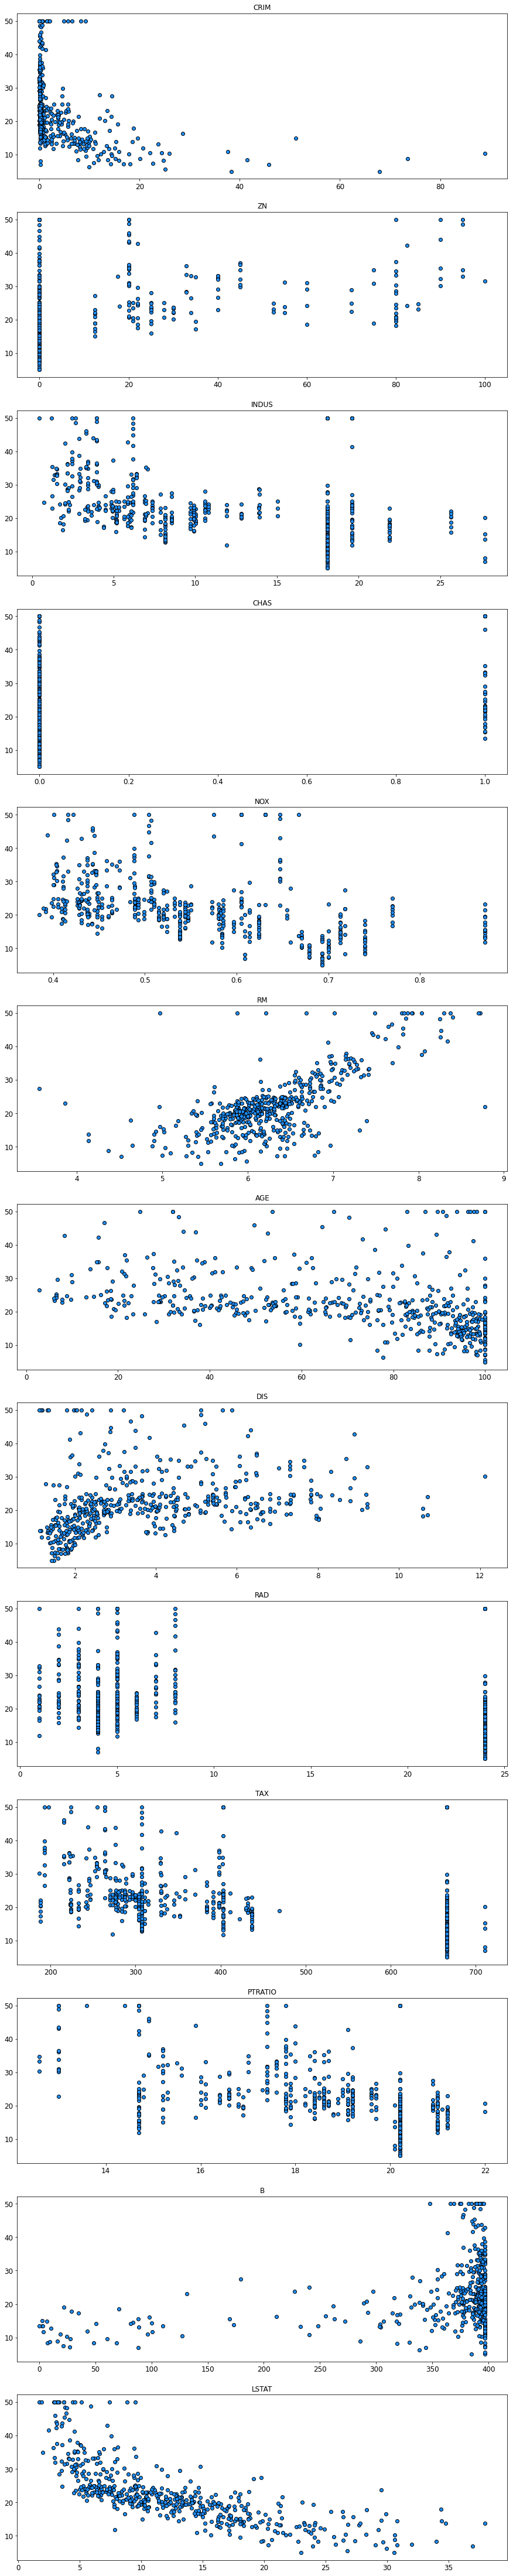

In [32]:
fig, axes = plt.subplots(13,figsize=(15, 80))

for ax, feature in zip(axes,boston['feature_names']):
    selector = (boston['feature_names'] == feature)
    ax.scatter(X[:, selector], y, facecolor="dodgerblue", edgecolor="k", label="datos")
    ax.set_title(feature)
    #ax.show()
    ax.tick_params(labelsize=12)

### 2. Estudie las gráficas, identificando **a ojo** los atributos que a su criterio sean los más informativos para la predicción.

- **CRIM**

Se observa que los valores analizados de la variable `CRIM` se encuentran concentrados en zonas de bajo crimen, es decir tenemos baja frecuencia de viviendas ubicadas en lugares con alta delincuencia. Sin embargo, vemos que en los lugares donde la delincuencia es baja los precios de las residencias también son bajos. 
    
- **ZN**

Si bien, observamos que en las viviendas de menor área construida, los precios son variados, no existen valores bajos para casas con mas de 15 sq.ft aproxidamente. 

- **INDUS**

Se observa que las viviendas con precios más altos se encuentran en lugares poco industriales.

- **CHAS**

En primer lugar, observamos que en este *dataset* tenemos mayor concentración de viviendas en zonas lejanas a Charles River. Sin embargo, en el grupo de casas cercanos a este rio el rango de precios arranca arriba de los 15 mil.
  
- **NOX**

La mayor concentración de viviendas se encuentra a niveles bajos de oxido nitrógeno. No se observa una relación concluyente. Se podría realizar un análisis conjunto con la variable INDUS. 
    
- **RM**

Observamos una fuerte relación positiva entre el número de habitaciones y el precio de las viviendas. 

- **AGE**

Podemos observar que los valores más bajos de viviendas corresponden a las propiedades mas antiguas. 

- **DIS**

Podemos observar que los valores más bajos de viviendas corresponden a las propiedades más cercanas a los conglomerados laborales. 

- **RAD**

A simple vista no se observa un patrón concluyente. 

- **TAX**

Se observa una concentración de casas en lugares donde el costo de los servicios públicos es más barato.

- **PTRATIO**

A simple vista no se observa un patrón concluyente. 

- **B**

La mayoría de las casas de este *dataset* están en regiones donde el índice `B` es alto. También vemos que los precios son más altos en esta zona. 

- **LSTAT**

Se observa una relación negativa entre los sectores en donde residen las personas con baja educación y los precios de las casas. Es decir a mayor porcentaje de status bajo social, los precios son mas bajos. 

### 3. Para ud., ¿cuáles son esos atributos? Lístelos en orden de importancia.

#### Correlación de todas las variables con 'target'.

In [8]:
corr = df.corr()
corr=corr[['TARGET']]
corr.loc[:,'abs_corr']=np.abs(corr['TARGET'])
corr.sort_values(by='abs_corr',ascending = False).style.background_gradient()

,TARGET,abs_corr
TARGET,1.000000,1.000000
LSTAT,-0.737663,0.737663
RM,0.695360,0.695360
PTRATIO,-0.507787,0.507787
INDUS,-0.483725,0.483725
TAX,-0.468536,0.468536
NOX,-0.427321,0.427321
CRIM,-0.388305,0.388305
RAD,-0.381626,0.381626
AGE,-0.376955,0.376955


El orden de importancia esta asociado a la correlación lineal de todos los atributos con `Target `

## Ejercicio 3: Regresión Lineal

#### División en Entrenamiento y Evaluación

Dividimos aleatoriamente los datos en 80% para entrenamiento y 20% para evaluación:

In [38]:
X, y = boston['data'], boston['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train.shape, X_test.shape

((404, 13), (102, 13))

### 1. Seleccione **un solo atributo** que considere puede ser el más apropiado.

In [88]:
feature = 'RM'  # selecciono el atributo 'RM'
selector = (boston['feature_names'] == feature)
X_train_fs = X_train[:, selector]
X_test_fs = X_test[:, selector]

### 2. Instancie una regresión lineal de **scikit-learn**, y entrénela usando sólo el atributo seleccionado.

In [89]:
reg = LinearRegression()
reg.fit(X_train_fs, y_train)

print(f'W:{reg.coef_, reg.intercept_}')

W:(array([9.37638431]), -36.476189627647315)


### 3. Evalúe, calculando error cuadrático medio para los conjuntos de entrenamiento y evaluación.

In [90]:
y_predict=reg.predict(X_test_fs)
print(f'Train error: {reg.score(X_train_fs, y_train):f}')
print(f'Test error: {reg.score(X_test_fs, y_test):f}')

Train error: 0.497080
Test error: 0.423944


### 4. Grafique el modelo resultante, junto con los puntos de entrenamiento y evaluación.

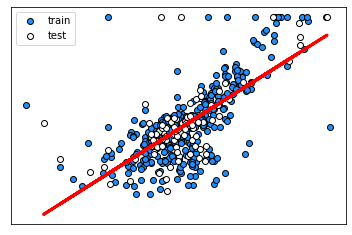

In [91]:
plt.scatter(X_train_fs, y_train, color="dodgerblue",edgecolor="k", label="train")
plt.scatter(X_test_fs, y_test, color="white", edgecolor="k", label="test")
plt.plot(X_test_fs, y_predict, color='red', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.legend()
plt.show()

### 5. Interprete el resultado, haciendo algún comentario sobre las cualidades del modelo obtenido.

Al realizar una regresión lineal únicamente con el atributo `RM`, nuestro modelo muestra que a medida que aumenta el número de habitaciones, también aumenta el precio de las viviendas. Se obtuvo un valor más alto de error para el conjunto de testeo respecto al calculado para el conjunto de entrenamiento. 

## Ejercicio 4: Regresión Polinomial

### 1. Entrenamiento y evaluación para varios grados de polinomio

In [200]:
feature = 'RM'  # selecciono el atributo 'RM'
selector = (boston['feature_names'] == feature)
X_train_fsp = X_train[:, selector]
X_test_fsp = X_test[:, selector]
#X_train_fsp.shape,X_test_fsp.shape

train_errors = []
test_errors = []
degrees = [0,1,2,3,4,5,6,7,8,9,10,11,12]
for degree in degrees:
    # train:
    pf = PolynomialFeatures(degree)
    lr = LinearRegression(fit_intercept=False)
    model = make_pipeline(pf, lr)
    model.fit(X_train_fsp, y_train)
    
    # predict:
    y_train_pred = model.predict(X_train_fsp)
    y_test_pred = model.predict(X_test_fsp)
    
    # evaluate:
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    train_errors.append(train_error)
    test_errors.append(test_error)
    print(f'Grado {degree}: Train error {train_error.round(3)},Test error {test_error.round(3)}')                   

Grado 0: Train error 85.144,Test error 81.582
Grado 1: Train error 42.82,Test error 46.907
Grado 2: Train error 37.746,Test error 39.795
Grado 3: Train error 36.396,Test error 39.826
Grado 4: Train error 34.808,Test error 41.554
Grado 5: Train error 33.131,Test error 41.038
Grado 6: Train error 33.13,Test error 41.009
Grado 7: Train error 33.06,Test error 42.394
Grado 8: Train error 33.06,Test error 42.399
Grado 9: Train error 32.855,Test error 46.04
Grado 10: Train error 32.8,Test error 44.974
Grado 11: Train error 32.754,Test error 43.754
Grado 12: Train error 32.718,Test error 42.53


### 2. Grafique las curvas de error en términos del grado del polinomio.

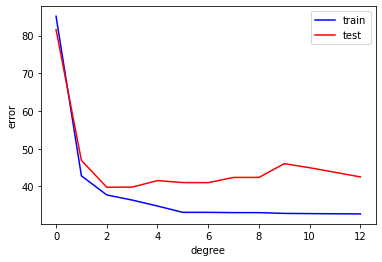

In [201]:
plt.plot(degrees, train_errors, color="blue", label="train")
plt.plot(degrees, test_errors, color="red", label="test")
plt.legend()
plt.xlabel("degree")
plt.ylabel("error")
plt.show()

### 3. Interprete la curva, identificando el punto en que comienza a haber sobreajuste, si lo hay.

El mejor grado del polinomio es el grado 2, en donde el nivel de error en test alcanza su punto mínimo. Observamos que a partir de allí comienza a subir ligeramente, a pesar de que el error en train cae, esto quiero decir que nuestro modelo está adaptandose más a nuestros datos de entrenamiento, y alejandose de una mejor predicción en test. 

### 4. Seleccione el modelo que mejor funcione, y grafique el modelo conjuntamente con los puntos.

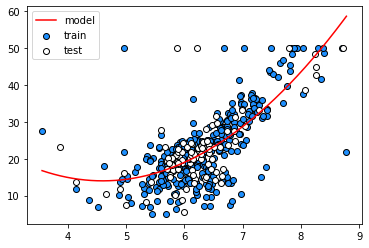

Train error: 37.745529
Test error: 39.794731


In [202]:
degree = 2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train_fsp, y_train);

plt.scatter(X_train_fsp, y_train, color="dodgerblue", edgecolor="k", label="train")
plt.scatter(X_test_fsp, y_test, color="white", edgecolor="k", label="test")
plt.plot(x, model.predict(x.reshape(-1, 1)), color="red", label="model")
plt.legend()
plt.show()

print(f'Train error: {train_errors[degree]:f}')
print(f'Test error: {test_errors[degree]:f}')


### 5. Interprete el resultado, haciendo algún comentario sobre las cualidades del modelo obtenido.

Podemos observar que el modelo polinomial de grado 2 se adapta mejor al comportamiento de nuestros datos, en comparación al modelo de regresión lineal. Si bien, los errores en train y test disminuyen, el modelo se complejiza un poco más. 

## Ejercicio 5: Regresión con más de un Atributo

### 1. Seleccione dos o tres atributos entre los más relevantes encontrados en el ejercicio 2.

In [203]:
selector = (boston['feature_names'] == 'RM') | (boston['feature_names'] == 'LSTAT') | (boston['feature_names'] == 'PTRATIO')
X_train_fsp3 = X_train[:, selector]
X_test_fsp3 = X_test[:, selector]
X_train_fsp3.shape, X_test_fsp3.shape

((404, 3), (102, 3))

### 2. Repita el ejercicio anterior, pero usando los atributos seleccionados. No hace falta graficar el modelo final.

In [204]:
train_errors_p3 = []
test_errors_p3 = []
degrees = [1,2,3,4,5,6,7,8,9,10,11,12]
for degree in degrees:
    # train:
    pf = PolynomialFeatures(degree)
    lr = LinearRegression(fit_intercept=False)
    model = make_pipeline(pf, lr)
    model.fit(X_train_fsp3, y_train)
    
    # predict:
    y_train_pred = model.predict(X_train_fsp3)
    y_test_pred = model.predict(X_test_fsp3)
    
    # evaluate:
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    train_errors_p3.append(train_error)
    test_errors_p3.append(test_error)
    print(f'Grado {degree}: Train error {train_error.round(3)},Test error {test_error.round(3)}')                   

Grado 1: Train error 23.682,Test error 41.678
Grado 2: Train error 14.171,Test error 30.008
Grado 3: Train error 12.53,Test error 30.978
Grado 4: Train error 9.51,Test error 37.901
Grado 5: Train error 8.2,Test error 32.222
Grado 6: Train error 7.092,Test error 111.716
Grado 7: Train error 6.52,Test error 6956.617
Grado 8: Train error 5.254,Test error 22566.823
Grado 9: Train error 4.782,Test error 11629.471
Grado 10: Train error 5.028,Test error 81542.094
Grado 11: Train error 31.072,Test error 310973.508
Grado 12: Train error 3.742,Test error 66810077.323


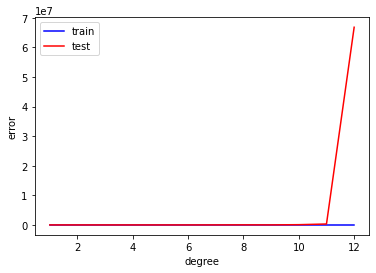

Grado:  2
Train error: 14.171189
Test error: 30.008299


In [205]:
plt.plot(degrees, train_errors_p3, color="blue", label="train")
plt.plot(degrees, test_errors_p3, color="red", label="test")
plt.legend()
plt.xlabel("degree")
plt.ylabel("error")
plt.show()

degree_p3=2 
print('Grado: ' , degree_p3)
print(f'Train error: {train_errors_p3[degree_p3 -1]:f}')
print(f'Test error: {test_errors_p3[degree_p3 -1]:f}')

### 3. Interprete el resultado y compare con los ejercicios anteriores. ¿Se obtuvieron mejores modelos? ¿Porqué?

Podemos observar que con la inclusión de dos features más se disminuyen los errores, es decir nuestro modelo predice mejor la variable objetivo. 

## Ejercicio 6: A Todo Feature

In [206]:
train_errors_all = []
test_errors_all = []
degrees = [1,2,3,4,5,6,7,8]
for degree in degrees:
    # train:
    pf = PolynomialFeatures(degree)
    lr = LinearRegression(fit_intercept=False)
    model = make_pipeline(pf, lr)
    model.fit(X_train, y_train)
    
    # predict:
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # evaluate:
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    train_errors_all.append(train_error)
    test_errors_all.append(test_error)
    print(f'Grado {degree}: Train error {train_error.round(3)},Test error {test_error.round(3)}')                   

Grado 1: Train error 19.326,Test error 33.449
Grado 2: Train error 4.34,Test error 31.278
Grado 3: Train error 0.0,Test error 976575.004
Grado 4: Train error 0.0,Test error 950756.908
Grado 5: Train error 0.0,Test error 195453.639
Grado 6: Train error 0.0,Test error 200691.242
Grado 7: Train error 0.0,Test error 24919.63
Grado 8: Train error 0.0,Test error 142027.863


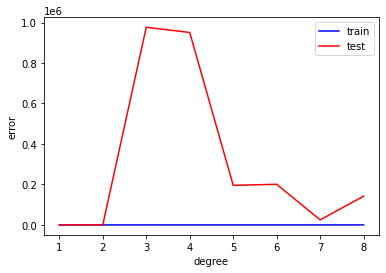

Grado:  1
Train error: 19.326470
Test error: 33.448980


In [175]:
plt.plot(degrees, train_errors_all, color="blue", label="train")
plt.plot(degrees, test_errors_all, color="red", label="test")
plt.legend()
plt.xlabel("degree")
plt.ylabel("error")
plt.show()

degree_all=1
print('Grado: ' , degree_all)
print(f'Train error: {train_errors_all[degree_all -1]:f}')
print(f'Test error: {test_errors_all[degree_all -1]:f}')